## Libraries

In [1]:
import cooler

from cooltools import insulation
import cooltools

import numpy as np
import pandas as pd

import bioframe

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
import bbi

import tad_common

from coolpuppy import coolpup
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
from matplotlib.colors import LogNorm, Normalize
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


## Get boundaries

In [2]:
resolution = 10000
NPROC = 8

In [3]:
windows = [50*resolution]
sample_names = {'Control' : 0, '12min': 12}

clr_ = [cooler.Cooler(f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t{sample}_q30.mcool::resolutions/{resolution}") for sample in sample_names.values()]
insulation_table_ = [insulation(clr, windows, verbose=False, nproc = NPROC, ignore_diags = None) for clr in clr_]

In [4]:
accepted_range = 1
only_strong_base = True

switch_df = tad_common.boundary_switch(
    ins_df_list=insulation_table_, 
    sample_names=list(sample_names.keys()), 
    window=windows[0], 
    only_strong_base=only_strong_base, 
    accepted_range=accepted_range)

Processing 12min and Control
Sample1 index: 1, Sample2 index: 0
Total #bins to process of 12min: 3718
Processing Control and 12min
Sample1 index: 0, Sample2 index: 1
Total #bins to process of Control: 3721


In [5]:
#test_comb =[('Control', '12min'),  ('12min', '30min'), ('30min', '60min')]
test_comb =[('Control', '12min')]

test_df = switch_df[switch_df.apply(lambda x: (x['sample1'], x['sample2']) in test_comb, axis=1)]

## BS change ~ Repair

In [130]:
test_comb =[('Control', '12min')]

bs_rep_df = switch_df[switch_df.apply(lambda x: (x['sample1'], x['sample2']) in test_comb, axis=1)]

bs_rep_df = bs_rep_df[bs_rep_df['case'].isin(['Preserved'])].reset_index(inplace=False, drop=True)
bs_rep_df['bs_change'] = bs_rep_df.apply(lambda x: x['bs2'] - x['bs1'], axis=1)

bins = clr_[0].bins()[:]
idx = bs_rep_df['idx1']
merged_df = pd.concat([bs_rep_df, bins.iloc[idx, [0,1,2]].reset_index(inplace=False, drop=True)], axis=1)

stack_ups_ = prep_stackups(
    merged_df,
    nbins=1,
    flank=0,
)

In [131]:
for k,v in stack_ups_.items():
    merged_df[k] = v.flatten().tolist()

merged_df.dropna(inplace=True)

In [132]:
for k,v in stack_ups_.items():
    print(k, np.corrcoef(merged_df['bs_change'], merged_df[k])[0,1])

xr-64 0.09304805101491458
xr-64-sim 0.0383523141453445
xr-cpd 0.12263301708633172
xr-cpd-sim 0.035366128147668915
ds-64 0.041648052252836694
ds-64-sim -0.023350146734993707
ds-cpd 0.007498610954153441
ds-cpd-sim -0.020914836573744173
ctcf 0.09175010067178475
xr-64-over-sim 0.11637121173013076
xr-cpd-over-sim 0.12611856917442163
ds-64-over-sim 0.04779818415053907
ds-cpd-over-sim 0.01946572188563842
rep-eff-64 0.05109782408352301
rep-eff-cpd 0.1101469598496286


(0.4, 2.1)

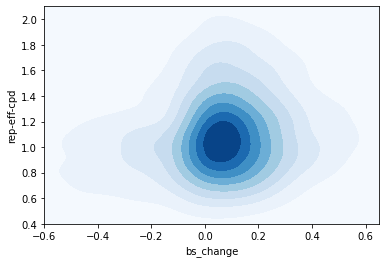

In [140]:
sns.kdeplot(x=merged_df['bs_change'], y=merged_df['rep-eff-cpd'], cmap="Blues", shade=True, thresh=0)
# limit x y axis
plt.xlim(-0.60, 0.65)
plt.ylim(0.40, 2.1)

## Genes overlap

In [82]:
# import gtf
gtf_path = "/cta/users/vkaya/refs/GRCh38.gtf"
genes = bioframe.read_table(gtf_path, schema='gtf').query('feature=="gene"')

# Define a function to extract key-value pairs from attributes
def parse_attributes(attribute_str):
    attributes = {}
    parts = attribute_str.split(';')
    for part in parts:
        key_value = part.strip().split(' "')
        if len(key_value) == 2:
            key, value = key_value
            attributes[key.strip()] = value.strip('"')
    return attributes

# Apply the extract_attributes function to the attributes column
genes['attributes'] = genes['attributes'].apply(parse_attributes)

# Create new columns for each attribute
genes_df = pd.concat([genes.drop(['attributes'], axis=1), genes['attributes'].apply(pd.Series)], axis=1)

# Update coord of gene start, based on strand
tss_parsed_df = genes_df.copy()
tss_parsed_df.loc[genes_df['strand'] == '+', 'end'] = genes_df['start'] + 1
tss_parsed_df.loc[genes_df['strand'] == '-', 'start'] = genes_df['end'] - 1
tss_parsed_df.start = tss_parsed_df.start.astype(int)
tss_parsed_df.end = tss_parsed_df.end.astype(int)


In [ ]:
n_flank = 1

# convert below code to function, not unique to lost_df

def overlap_boundaries_to_tss(b_df, tss_parsed_df, resolution, n_flank=1):
    bins_df = clr_[0].bins()[:]
    b_coords = bins_df.loc[b_df['idx1'], ['chrom', 'start', 'end']]
    b_coords.start = b_coords.start - (n_flank*resolution)
    b_coords.end = b_coords.end + (n_flank*resolution)
    df = bioframe.overlap(tss_parsed_df, b_coords, how='right')
    return df.dropna()

lost_df = test_df[test_df['case'] == 'Lost']
preserved_df = test_df[test_df['case'].isin(['Preserved', 'Shifted'])]

# get the background as all genes tss at stronng boundaries
t0_ins = insulation_table_[0]
t0_all_strong = t0_ins.loc[t0_ins['is_boundary_500000'] == True].iloc[:, 0:3]

t0_all_strong.start = t0_all_strong.start - (n_flank*resolution)
t0_all_strong.end = t0_all_strong.end + (n_flank*resolution)
bg_tss_df = bioframe.overlap(tss_parsed_df, t0_all_strong, how='right').dropna()
preserved_tss_df = overlap_boundaries_to_tss(preserved_df, tss_parsed_df, resolution, n_flank=n_flank)
lost_tss_df = overlap_boundaries_to_tss(lost_df, tss_parsed_df, resolution, n_flank=n_flank)

ensembl_gene_ids = preserved_tss_df.gene_id.apply(lambda x: x.split('.')[0]).values
# Convert Ensembl gene IDs to Entrez gene IDs
mg = mygene.MyGeneInfo()
results = mg.getgenes(ensembl_gene_ids, fields="symbol")
# Extract the Entrez gene IDs from the results
entrez_gene_ids = [result.get("symbol", None) for result in results]

In [ ]:
for i in pd.Series(entrez_gene_ids).dropna().values:
    print(i)

## Get expected

In [12]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr_[0].chromnames)].reset_index(drop=True)

#hg38_arms = pd.read_csv("/cta/users/vkaya/hi-c/work/hela/notebooks/hg38_arms.csv", sep="\t")

In [13]:
expected_ = [cooltools.expected_cis(
        clr=clr,
        view_df=hg38_arms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=NPROC,
        clr_weight_name='weight') for clr in clr_]

## Get bw data

In [18]:
import bbi
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]
def get_mean_bw(bw, chrom_sizes):
    for chrom in chrom_sizes.index:
        start, end = 0, chrom_sizes.loc[chrom] // 10000 * 10000
        yield np.nanmean(bbi.fetch(bw, chrom, start, end, bins=chrom_sizes.loc[chrom] // 1000))

BWS = {
    'xr-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_real_over_sim_res1000.bw',
    'xr-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw',
    'ds-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_64_real_over_sim_res1000.bw',
    'ds-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_CPD_real_over_sim_res1000.bw',
    'rep-eff-64': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_rep_eff_res1000.bw',
    'rep-eff-cpd': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_rep_eff_res1000.bw',
    'ctcf': '/home/carlos/Desktop/manuscripts/notebooks/bws/ctcf.foi.bigWig',
    }

MEANS_BW = {}
for k in BWS:
    if k != 'ctcf':
        curr_mean = np.mean(list(get_mean_bw(BWS[k], chrom_sizes)))
        MEANS_BW[k] = curr_mean
        print(k, curr_mean)
    elif k == 'ctcf':
        MEANS_BW[k] = 1

xr-64-over-sim 1.1196280573820672
xr-cpd-over-sim 1.1868305407819189
ds-64-over-sim 1.23405186005681
ds-cpd-over-sim 1.2698717973554339
rep-eff-64 1.482119054797605
rep-eff-cpd 1.567885930820114


In [19]:
def prep_stackups(regions, nbins, flank):

    stackups = {k: bbi.stackup(v,
                        regions.chrom,
                        regions.start-flank,
                        regions.end+flank,
                        bins=nbins) / MEANS_BW[k] for k, v in BWS.items()}
    return stackups

In [20]:
flank = 500_000
nbins = (flank * 2 + 10_000) // 1000 # 1000 bp is bw files' resolution
#nbins /= 10 # smooth by 10
nbins = int(nbins)
bins = clr_[0].bins()[:]

In [21]:
idx_preserved = test_df.loc[(test_df['sample1'] == 'Control') & (test_df['sample2'] == '12min') & (test_df['case'].isin(['Preserved', 'Shifted']))].idx2
preserved_boundaries = bins.loc[idx_preserved]
stackups_preserved = prep_stackups(preserved_boundaries, nbins, flank)

idx_lost = test_df.loc[(test_df['sample1'] == 'Control') & (test_df['sample2'] == '12min') & (test_df['case'].isin(['Lost']))].idx1
lost_boundaries = bins.loc[idx_lost]
stackups_lost = prep_stackups(lost_boundaries, nbins, flank)

## Viz

In [14]:
pup_preserved_ = [coolpup.pileup(
    clr, 
    preserved_boundaries, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_preserved_ = divide_pups(pup_preserved_[1], pup_preserved_[0])

pup_lost_ = [coolpup.pileup(
    clr, 
    lost_boundaries, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_lost_ = divide_pups(pup_lost_[1], pup_lost_[0])

INFO:coolpuppy:('chr1_p', 'chr1_p'): 160
INFO:coolpuppy:('chr2_p', 'chr2_p'): 109
INFO:coolpuppy:('chr4_p', 'chr4_p'): 51
INFO:coolpuppy:('chr3_p', 'chr3_p'): 102
INFO:coolpuppy:('chr5_p', 'chr5_p'): 36
INFO:coolpuppy:('chr6_p', 'chr6_p'): 83
INFO:coolpuppy:('chr8_p', 'chr8_p'): 54
INFO:coolpuppy:('chr7_p', 'chr7_p'): 67
INFO:coolpuppy:('chr2_q', 'chr2_q'): 149
INFO:coolpuppy:('chr4_q', 'chr4_q'): 135
INFO:coolpuppy:('chr1_q', 'chr1_q'): 132
INFO:coolpuppy:('chr3_q', 'chr3_q'): 112
INFO:coolpuppy:('chr9_p', 'chr9_p'): 43
INFO:coolpuppy:('chr5_q', 'chr5_q'): 155
INFO:coolpuppy:('chr6_q', 'chr6_q'): 116
INFO:coolpuppy:('chr10_p', 'chr10_p'): 44
INFO:coolpuppy:('chr8_q', 'chr8_q'): 112
INFO:coolpuppy:('chr7_q', 'chr7_q'): 95
INFO:coolpuppy:('chr11_p', 'chr11_p'): 64
INFO:coolpuppy:('chr12_p', 'chr12_p'): 47
INFO:coolpuppy:('chr9_q', 'chr9_q'): 102
INFO:coolpuppy:('chr10_q', 'chr10_q'): 104
INFO:coolpuppy:('chr16_p', 'chr16_p'): 28
INFO:coolpuppy:('chr13_q', 'chr13_q'): 88
INFO:coolpuppy:(

In [22]:

bw_dict_to_plot_preserved = {
    'CPD': stackups_preserved['xr-cpd-over-sim'],
    '(6-4)PP': stackups_preserved['xr-64-over-sim'],
    # 'CPD': stackups_preserved['rep-eff-cpd'],
    # '(6-4)PP': stackups_preserved['rep-eff-64'],
}

bw_dict_to_plot_lost = {
    'CPD': stackups_lost['xr-cpd-over-sim'],
    '(6-4)PP': stackups_lost['xr-64-over-sim'],
    # 'CPD': stackups_lost['rep-eff-cpd'],
    # '(6-4)PP': stackups_lost['rep-eff-64'],
}

bw_dict_to_plot_preserved_ds = {
    'CPD': stackups_preserved['ds-cpd-over-sim'],
    '(6-4)PP': stackups_preserved['ds-64-over-sim'],

}

bw_dict_to_plot_lost_ds = {
    'CPD': stackups_lost['ds-cpd-over-sim'],
    '(6-4)PP': stackups_lost['ds-64-over-sim'],

}

bw_dict_to_plot_preserved_ctcf = {
    'CTCF': stackups_preserved['ctcf'],

}

bw_dict_to_plot_lost_ctcf = {
    'CTCF': stackups_lost['ctcf'],
}


def make_bw_df(bw_dict, sigma):
    bw_data = {
    'n': [],
    'val': [],
    'name': []
    }

    labels = list(range(len(bw_dict.keys())))
    for i, k in enumerate(bw_dict.keys()):
        val = np.nanmean(bw_dict[k], axis=0)
        val = gaussian_filter1d(val, sigma = sigma) if sigma is not None else val
        bw_data['n'].extend(np.arange(len(val)).tolist())
        bw_data['val'].extend(val)
        #bw_data['name'].extend([labels[i]] * len(val))
        bw_data['name'].extend([k] * len(val))

    bw_df = pd.DataFrame(bw_data)
    return bw_df


sigma = 1
# preserved bw
bw_df_preserved_repair_eff = make_bw_df(bw_dict_to_plot_preserved, sigma=sigma)
bw_df_preserved_ds = make_bw_df(bw_dict_to_plot_preserved_ds, sigma=sigma)
bw_df_preserved_ctcf = make_bw_df(bw_dict_to_plot_preserved_ctcf, sigma=sigma)
# lost bw
bw_df_lost_repair_eff = make_bw_df(bw_dict_to_plot_lost, sigma=sigma)
bw_df_lost_ds = make_bw_df(bw_dict_to_plot_lost_ds, sigma=sigma)
bw_df_lost_ctcf = make_bw_df(bw_dict_to_plot_lost_ctcf, sigma=sigma)

/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_23294/3145808223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)


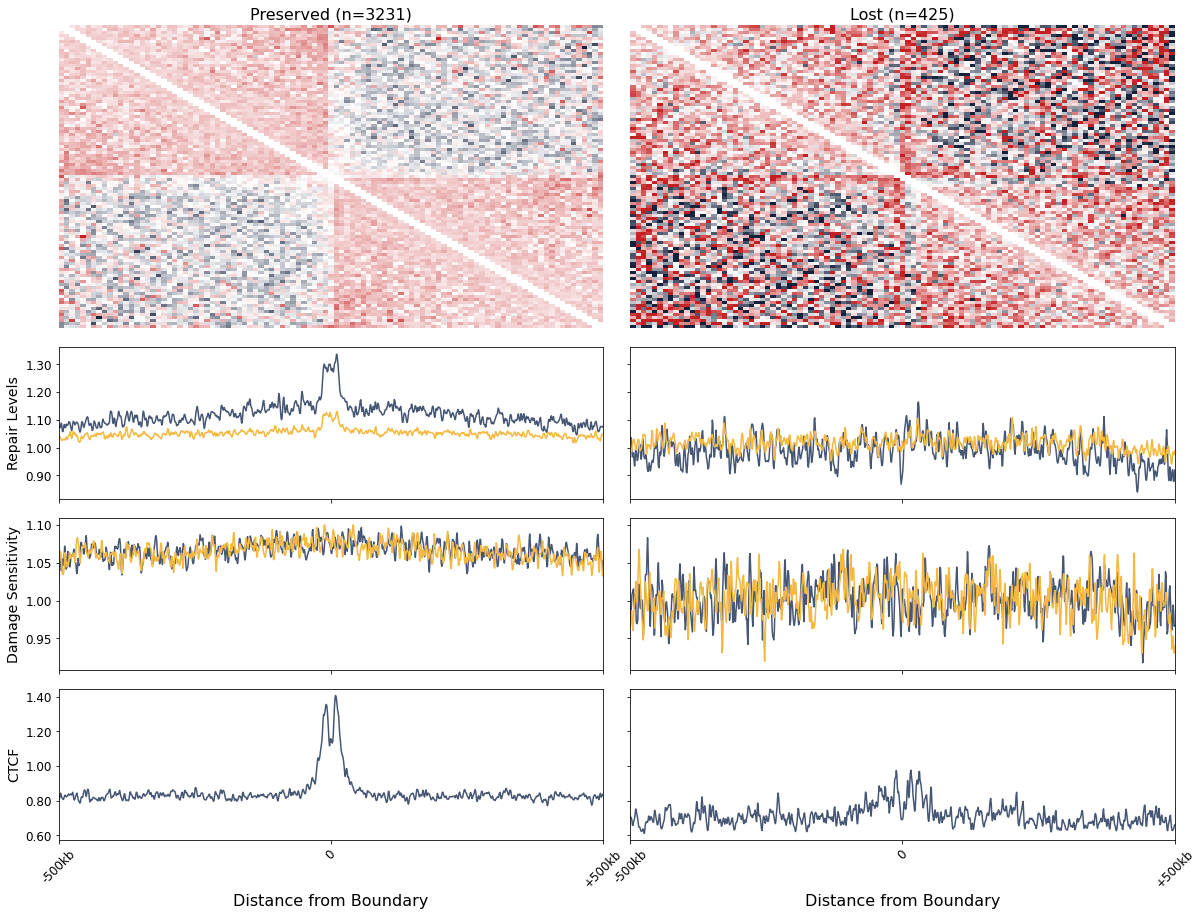

In [23]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)


height_ratios = np.array([1, .5, .5, .5])
width_ratios = np.array([1, 1])
fig, ax = plt.subplots(
    nrows=4, 
    ncols=2, 
    sharex='row', 
    sharey='row', 
    figsize=(20, 15), 
    gridspec_kw={'height_ratios':height_ratios,
                 'width_ratios':width_ratios,
                 'hspace':0.10,
                 'wspace':0.05})

#norm colors to preserved data
vmin, vmax = plotpup.get_min_max(
            pup_divide_preserved_.data[0], 
            sym=False, 
            scale="log",
            vmin=None,
            vmax=None,
            )

norm = LogNorm(vmin=vmin, vmax=vmax)

hm = sns.heatmap(
    pup_divide_preserved_.data[0], 
    ax=ax[0,0], 
    cmap=cmp, 
    norm=norm, 
    cbar=False, 
    xticklabels=False, 
    yticklabels=False)
hm.set_title(f'Preserved (n={len(preserved_boundaries)})', fontsize=16)

hm = sns.heatmap(
    pup_divide_lost_.data[0], 
    ax=ax[0,1], 
    cmap=cmp, 
    norm=norm, 
    cbar=False, 
    xticklabels=False, 
    yticklabels=False)
hm.set_title(f'Lost (n={len(lost_boundaries)})', fontsize=16)

def plot_bw(bw_df, palette, ax=None, ylabel=None, armlabel=250, xlabel=False):
    l = sns.lineplot(data=bw_df, x='n', y='val', hue='name', ax=ax, legend=False, palette=palette)
    end = bw_df['n'].max()
    l.set_xticks([0, end//2, end])
    if xlabel:
        l.set_xticklabels([f"-{armlabel}kb", 0, f"+{armlabel}kb"])
        l.set_xlabel('Distance from Boundary', fontsize=16)
    else:
        # remove xticks, xlabel
        l.set_xticklabels([])
        l.set_xlabel('')
    l.set_ylabel(ylabel, fontsize=14)
    yticks = [f"{i:.2f}" for i in l.get_yticks()]
    l.set_yticklabels(yticks)
    #increase tick size
    l.tick_params(axis='both', which='major', labelsize=12)

    
plot_bw(bw_df_preserved_repair_eff, ax=ax[1,0], ylabel='Repair Levels', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(bw_df_lost_repair_eff, ax=ax[1,1], ylabel='Repair Levels', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[1,0].margins(x=0)
ax[1,1].margins(x=0)
plot_bw(bw_df_preserved_ds, ax=ax[2,0], ylabel='Damage Sensitivity', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(bw_df_lost_ds, ax=ax[2,1], ylabel='Damage Sensitivity', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[2,0].margins(x=0)
ax[2,1].margins(x=0)
#ax[2,0].set_yticks([1.0, 1.02, 1.04, 1.06])
#ax[2,1].set_yticks([1.0, 1.02, 1.04, 1.06])

plot_bw(bw_df_preserved_ctcf, ax=ax[3,0], ylabel='CTCF', palette=['#465775'], xlabel=True, armlabel=flank//1000)
plot_bw(bw_df_lost_ctcf, ax=ax[3,1], ylabel='CTCF', palette=['#465775'], xlabel=True, armlabel=flank//1000)
ax[3,0].margins(x=0)
ax[3,1].margins(x=0)
for tick in ax[3,0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(45)

fig.savefig(f"preserved_lost.svg", bbox_inches='tight')
fig.savefig(f"preserved_lost.png", bbox_inches='tight', dpi=600)

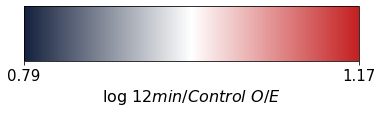

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

custom_cmap = cmp

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')

# Set the desired tick positions and labels
tick_positions = [0,  1]
vmin, vmax = (norm.vmin), norm.vmax
tick_labels = ["%.2f" % round(vmin, 2), "%.2f" % round(vmax, 2)]

# Set the ticks and tick labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels, fontsize=15)

# Set color bar label
oe = "${O/E}$"
main_title = "${12min / Control}$" + f' {oe}'
#log_str = "log$_{2}$"
log_str = "log"

cbar.set_label(f'{log_str} {main_title}', fontsize=16)

# Remove the x-axis labels and ticks
#ax.set_xticks([])
#ax.set_xticklabels([])

# Show the color bar
plt.savefig(f"preserved_lost_colorbar.svg", bbox_inches='tight')

## 3D Model Nuclear Distances ~ Preserved/Lost 

In [79]:
model_data = pd.read_csv('/cta/users/vkaya/hi-c/work/hela/notebooks/boundaries/model_data.tsv', sep='\t')

def calc_distance(x):
    xyz = np.array([x['x'], x['y'], x['z']])
    return np.linalg.norm(xyz)

model_data['distance'] = model_data.apply(calc_distance, axis=1)

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
model_data.distance = scaler.fit_transform(model_data.distance.values.reshape(-1, 1))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Preserved vs. Lost: t-test independent samples, P_val:2.731e-01 t=-1.096e+00


(<Axes: title={'center': 'Boundary Distance Distribution'}, xlabel='Boundary State', ylabel='Distance To Nuclear Center (μm)'>,
 [<statannotations.Annotation.Annotation at 0x2b3b70aeab50>])

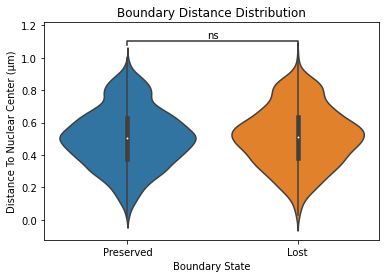

In [81]:
preserved_distance = bioframe.overlap(preserved_boundaries, model_data, how='left', cols1=['chrom', 'start', 'end'], cols2=['chrom', 'start', 'end'])
lost_distance = bioframe.overlap(lost_boundaries, model_data, how='left', cols1=['chrom', 'start', 'end'], cols2=['chrom', 'start', 'end'])
preserved_distance['sample'] = 'Preserved'
lost_distance['sample'] = 'Lost'
distance = pd.concat([preserved_distance, lost_distance])

#sns.boxplot(data=radius, x='sample', y='radius_', palette=['#1f77b4', '#ff7f0e'])
s = sns.violinplot(data=distance, x='sample', y='distance_', palette=['#1f77b4', '#ff7f0e'])
s.set_ylabel('Distance To Nuclear Center (μm)')
s.set_xlabel('Boundary State')
s.set_xticklabels(['Preserved', 'Lost'])
s.set_title('Boundary Distance Distribution')

from statannotations.Annotator import Annotator
pairs = [('Preserved', 'Lost')]
annotator = Annotator(s, pairs, data=distance, x='sample', y='distance_')
annotator.configure(test="t-test_ind")
annotator.apply_and_annotate()